### Importing Libaries ###

In [2]:
#Library imports
import re
import os
import time
import math
import random
import itertools
import warnings
import numpy as np
from numpy import array
import pandas as pd
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn import svm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import pmdarima as pm
from pmdarima.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM

warnings.filterwarnings("ignore")
#Notebook arguments
%matplotlib inline

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if sys.path[0] == '':


# Importing Data

In [112]:
#I'm using pandas to download my data into the notebook
index_df = pd.read_pickle('vix.pickle')

In [113]:
index_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-23,26.930000,28.549999,26.540001,26.910000,26.910000,0
1,2010-06-24,27.610001,30.270000,27.530001,29.740000,29.740000,0
2,2010-06-25,29.639999,30.410000,28.070000,28.530001,28.530001,0
3,2010-06-28,29.200001,29.900000,28.469999,29.000000,29.000000,0
4,2010-06-29,31.219999,35.389999,31.219999,34.130001,34.130001,0


In [114]:
index_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2513,2020-06-17,33.279999,35.169998,32.250000,33.470001,33.470001,0
2514,2020-06-18,33.830002,36.250000,32.240002,32.939999,32.939999,0
2515,2020-06-19,32.070000,35.119999,30.400000,35.119999,35.119999,0
2516,2020-06-22,35.220001,35.389999,31.639999,31.770000,31.770000,0
2517,2020-06-23,31.709999,31.709999,29.260000,31.370001,31.370001,0


In [115]:

type(index_df['Date'][2])

str

In [116]:
#Set the format of the date in the date column to datetime 
index_df['Date'] = pd.to_datetime(index_df['Date'])
#Put the date column as your index to avoid having to drop the column later on
index_df = index_df.set_index(['Date'])

In [117]:

#I chose to train my model on these 3 years where exogenous factors don't create alot of volatility in the index
training = index_df['2010-06-23':'2020-06-01'].copy()
training.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-23,26.930000,28.549999,26.540001,26.910000,26.910000,0
2010-06-24,27.610001,30.270000,27.530001,29.740000,29.740000,0
2010-06-25,29.639999,30.410000,28.070000,28.530001,28.530001,0
2010-06-28,29.200001,29.900000,28.469999,29.000000,29.000000,0
2010-06-29,31.219999,35.389999,31.219999,34.130001,34.130001,0


In [118]:
#I chose to test my model's performance on 2020
testing = index_df['2020-06-01':].copy()
testing.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-01,28.940001,30.60,28.110001,28.230000,28.230000,0
2020-06-02,28.400000,28.52,26.660000,26.840000,26.840000,0
2020-06-03,26.750000,26.98,25.040001,25.660000,25.660000,0
2020-06-04,26.230000,26.43,24.379999,25.809999,25.809999,0
2020-06-05,24.790001,25.09,23.540001,24.520000,24.520000,0


In [119]:
#dropping Volume 
train = training.drop(['Volume'],axis = 1)

In [120]:
#scaling my data allows me to pass it through my model 
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
train

array([[0.24321389, 0.25262603, 0.29089144, 0.24160434, 0.24160434],
       [0.252443  , 0.27521008, 0.30690827, 0.28008157, 0.28008157],
       [0.27999455, 0.27704832, 0.3156447 , 0.26363019, 0.26363019],
       ...,
       [0.25529315, 0.27022057, 0.30529039, 0.26444595, 0.26444595],
       [0.27538   , 0.27376575, 0.3030254 , 0.24976206, 0.24976206],
       [0.27049403, 0.27954306, 0.31629186, 0.25955132, 0.25955132]])

In [121]:
#I'm creating two empty lists that im going to create my training variables with 
X_train = []
y_train = []

In [122]:
# Then we are creating a for loop that iteraterates through our df and grabbes sets of 60 days of values. 
#we are then going to use these sets to predict 1 day ahead.
for i in range(30,train.shape[0]):
    X_train.append(train[i-30:i])
    y_train.append(train[i,0])

In [123]:
# we are turning our X & Y trains into arrays for the model take it 
X_train,y_train = np.array(X_train), np.array(y_train)

In [124]:
#Here I am checking to see whether my X & Y variables are structured properly 
X_train.shape, y_train.shape

((2472, 30, 5), (2472,))

In [125]:
#Because this model uses the past 60 days to predict 1 day into the future we need to add the 60 days previous from 2018 to get the first day of 2019. 
#we are taking the last 60 days of our training data and making a new datafrane
past_30_days = training.tail(30)

In [126]:
#Here we are adding testing data to the df we just created and dropping the Adj Close column
dff = past_30_days.append(testing)
dff = dff.drop(['Volume'],axis = 1)
dff.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2020-04-20,40.680000,43.830002,39.880001,43.830002,43.830002
2020-04-21,44.279999,47.770000,43.770000,45.410000,45.410000
2020-04-22,44.910000,45.070000,41.410000,41.980000,41.980000
2020-04-23,41.299999,42.470001,39.060001,41.380001,41.380001
2020-04-24,38.799999,40.169998,35.599998,35.930000,35.930000


In [127]:
#now we are scaling the dataframe list we just created and turning it into an array 
inputs =scaler.transform(dff)
inputs

array([[0.42983169, 0.45325632, 0.50671412, 0.47165195, 0.47165195],
       [0.47869161, 0.50498949, 0.5696489 , 0.49313391, 0.49313391],
       [0.48724211, 0.46953781, 0.53146737, 0.44649897, 0.44649897],
       [0.43824645, 0.43539917, 0.49344765, 0.43834127, 0.43834127],
       [0.40431594, 0.40519955, 0.43746961, 0.364242  , 0.364242  ],
       [0.37024973, 0.35622372, 0.3874777 , 0.32834807, 0.32834807],
       [0.32844732, 0.34243696, 0.35560589, 0.33215499, 0.33215499],
       [0.31853962, 0.3135504 , 0.35835622, 0.3003399 , 0.3003399 ],
       [0.29831704, 0.3496586 , 0.36191553, 0.34004081, 0.34004081],
       [0.39576543, 0.39732142, 0.45348647, 0.38137319, 0.38137319],
       [0.40879479, 0.40716911, 0.43633712, 0.36478586, 0.36478586],
       [0.35029858, 0.35333509, 0.37841773, 0.33269885, 0.33269885],
       [0.32138977, 0.34637603, 0.37404949, 0.33963288, 0.33963288],
       [0.31365362, 0.30160187, 0.35285552, 0.30319511, 0.30319511],
       [0.28678065, 0.2767857 , 0.

In [128]:
#now we are repeating what we did earlier 
#first we create two lists X and Y 
#then we are creating a for loop that iteraterates through our df and grabbes sets of 30 days of values. 
#we are then going to use these sets to predict 1 day ahead.
X_test = []
y_test = []

for i in range(30, inputs.shape[0]):
    X_test.append(inputs[i-30:i])
    y_test.append(inputs[i,0])

In [129]:
# we are turning our X & Y tests into arrays for the model
X_test, y_test = np.array(X_test), np.array(y_test)

In [130]:
#This is my base model
#First we initialize our model 
model1 = Sequential()
#Then add our lstm layer because this is a base model I randomly inputed 60 units
model1.add(LSTM(units = 60, activation='relu', input_shape=(X_train.shape[1],5)))
#now we add out dense layer 
model1.add(Dense(1))

In [131]:
#To check if we set up our model to our specifications we can use .summary()
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60)                15840     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 61        
Total params: 15,901
Trainable params: 15,901
Non-trainable params: 0
_________________________________________________________________


In [132]:
#Here I compiled my model using adam optimization and mean_squared_error for loss 
model1.compile(optimizer='adam', loss = 'mean_squared_error')

In [133]:
#Now I am fitting my model using my X and Y train, 10 epochs and a batch size of 200.
model1.fit(X_train,y_train,epochs=10,batch_size=200)

Epoch 1/10
13/13 [==============================] - 0s 18ms/step - loss: 0.0128
Epoch 2/10
13/13 [==============================] - 0s 18ms/step - loss: 0.0022
Epoch 3/10
13/13 [==============================] - 0s 18ms/step - loss: 0.0013
Epoch 4/10
13/13 [==============================] - 0s 18ms/step - loss: 9.7435e-04
Epoch 5/10
13/13 [==============================] - 0s 18ms/step - loss: 8.2961e-04
Epoch 6/10
13/13 [==============================] - 0s 18ms/step - loss: 7.3137e-04
Epoch 7/10
13/13 [==============================] - 0s 17ms/step - loss: 6.5909e-04
Epoch 8/10
13/13 [==============================] - 0s 18ms/step - loss: 6.2025e-04
Epoch 9/10
13/13 [==============================] - 0s 19ms/step - loss: 5.9750e-04
Epoch 10/10
13/13 [==============================] - 0s 21ms/step - loss: 5.3389e-04


In [135]:

#once we have fit our model we can now use it pass through our X_test and predict our y_test.
y_pred1 = model1.predict(X_test)

In [136]:

#checking to see the output of the model. We need to now scale our data back to values we can interpret.
y_pred1

array([[0.25706843],
       [0.2587312 ],
       [0.2523673 ],
       [0.24129207],
       [0.23293161],
       [0.22101972],
       [0.21927795],
       [0.22521308],
       [0.2317118 ],
       [0.28817263],
       [0.3270947 ],
       [0.3559563 ],
       [0.353659  ],
       [0.3474134 ],
       [0.3432238 ],
       [0.33954385],
       [0.33355466]], dtype=float32)

In [137]:

#using .scale_ on our scaler, we can take the first value and use it to scale our predictions. 
scaler.scale_

array([0.0135722 , 0.01313025, 0.01617861, 0.01359619, 0.01359619])

In [138]:
# Here I am setting up my scale
scale = 1/0.0135722
scale

73.6800223987268

In [139]:
# I created this function to stream line our scaling,graphing, and evaluation process
def ScaleGraphEval(y_pred,name):
    #this scales our prediction to normal values 
    y_pred=y_pred*scale
    #now with our normalized predictions we can graph them against the actual values of each day  
    plt.figure(figsize=(18,5))
    plt.plot(y_test, color = 'b', label = 'Actual VIX Value')
    plt.plot(y_pred ,color ='r', label = 'Predicted VIX Value')
    plt.title(name)
    plt.xlabel('Time')
    plt.ylabel('VIX Index Prediction')
    plt.legend()
    plt.show()
    # This line of code calculates the RMSE and displays it at the bottom of the graph.
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print('The RMSE of this Model is',rmse)

In [140]:
#Here we are scaling our y_test data back to normal.
#This is the only time we will run this code 
y_test = y_test*scale

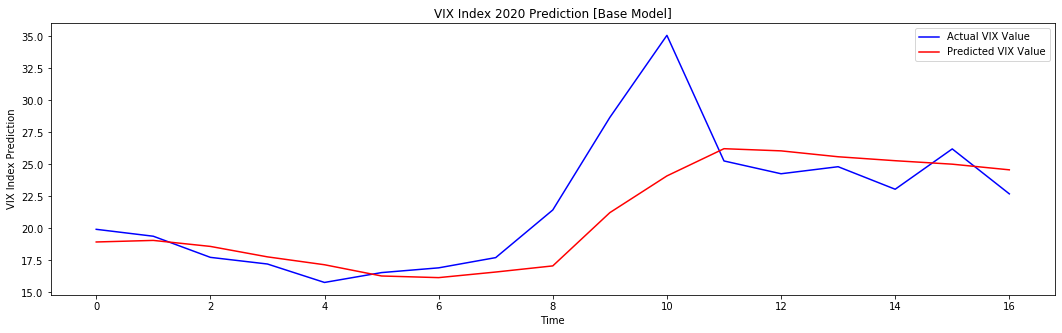

The RMSE of this Model is 3.5606395814838416


In [141]:
ScaleGraphEval(y_pred1,'VIX Index 2020 Prediction [Base Model]')

# Model 2 

In [142]:

# This is my second model
model2 = Sequential()
# After some trials I found that setting my units to 110 gets me the best rmse score 
model2.add(LSTM(units = 110, activation='relu', input_shape=(X_train.shape[1],5)))

model2.add(Dense(1))

In [143]:

#Here I see that my model is set up properly 
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 110)               51040     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 111       
Total params: 51,151
Trainable params: 51,151
Non-trainable params: 0
_________________________________________________________________


In [144]:
model2.compile(optimizer='adam', loss = 'mean_squared_error')
# After a few trials I found that increaseing my epochs to 80 and reducing my batch size to 50 gave me a lower rmse 
model2.fit(X_train,y_train,epochs=80,batch_size=50)

Epoch 1/80
50/50 [==============================] - 1s 14ms/step - loss: 0.0031
Epoch 2/80
50/50 [==============================] - 1s 13ms/step - loss: 7.8176e-04
Epoch 3/80
50/50 [==============================] - 1s 14ms/step - loss: 6.2920e-04
Epoch 4/80
50/50 [==============================] - 1s 14ms/step - loss: 6.0611e-04
Epoch 5/80
50/50 [==============================] - 1s 13ms/step - loss: 5.2278e-04
Epoch 6/80
50/50 [==============================] - 1s 13ms/step - loss: 4.9967e-04
Epoch 7/80
50/50 [==============================] - 1s 13ms/step - loss: 4.6511e-04
Epoch 8/80
50/50 [==============================] - 1s 13ms/step - loss: 4.3247e-04
Epoch 9/80
50/50 [==============================] - 1s 13ms/step - loss: 4.5570e-04
Epoch 10/80
50/50 [==============================] - 1s 13ms/step - loss: 4.0889e-04
Epoch 11/80
50/50 [==============================] - 1s 13ms/step - loss: 3.8427e-04
Epoch 12/80
50/50 [==============================] - 1s 13ms/step - loss: 3.77

In [146]:
y_pred2 = model2.predict(X_test)
y_pred2

array([[0.27280283],
       [0.26951894],
       [0.24881232],
       [0.23278588],
       [0.23290524],
       [0.21502522],
       [0.23436193],
       [0.25627986],
       [0.25704643],
       [0.4128843 ],
       [0.36414334],
       [0.36416098],
       [0.34741998],
       [0.33884245],
       [0.3341177 ],
       [0.35751826],
       [0.3138859 ]], dtype=float32)

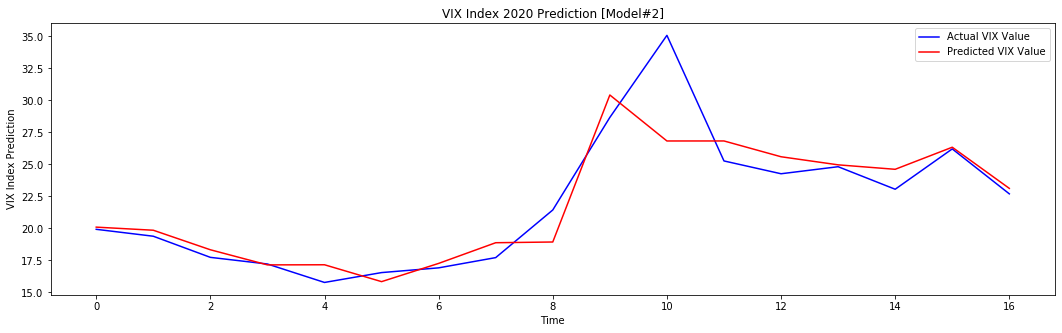

The RMSE of this Model is 2.284391800570448


In [148]:
ScaleGraphEval(y_pred2,'VIX Index 2020 Prediction [Model#2]')
#Here we got an RMSE of 2.28 though I suspect that there is an over fitting problem

# Model 3 

In [149]:
# This is my third model 
model3 = Sequential()
#In this model I am adding a second layer to see how my results vary 
model3.add(LSTM(units = 110, activation='relu',return_sequences = True, input_shape=(X_train.shape[1],5)))
model3.add(Dropout(0.2))
#After some experimination and research I found that lowering the number of units in my second layer increases performance 
model3.add(LSTM(units = 80, activation='relu'))
model3.add(Dropout(0.2))
#I added droupout of .2 to each layer to solve my overfitting problem 
model3.add(Dense(1))

In [150]:
# I see my model is set up exactly to my specifications 
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30, 110)           51040     
_________________________________________________________________
dropout (Dropout)            (None, 30, 110)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 80)                61120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 81        
Total params: 112,241
Trainable params: 112,241
Non-trainable params: 0
_________________________________________________________________


In [151]:
model3.compile(optimizer='adam', loss = 'mean_squared_error')

model3.fit(X_train,y_train,epochs=80,batch_size=50)

Epoch 1/80
50/50 [==============================] - 1s 26ms/step - loss: 0.0031
Epoch 2/80
50/50 [==============================] - 1s 25ms/step - loss: 0.0016
Epoch 3/80
50/50 [==============================] - 1s 25ms/step - loss: 0.0014
Epoch 4/80
50/50 [==============================] - 1s 25ms/step - loss: 0.0013
Epoch 5/80
50/50 [==============================] - 1s 25ms/step - loss: 0.0011
Epoch 6/80
50/50 [==============================] - 1s 25ms/step - loss: 9.5009e-04
Epoch 7/80
50/50 [==============================] - 1s 24ms/step - loss: 0.0010
Epoch 8/80
50/50 [==============================] - 1s 25ms/step - loss: 8.9881e-04
Epoch 9/80
50/50 [==============================] - 1s 26ms/step - loss: 8.5951e-04
Epoch 10/80
50/50 [==============================] - 1s 25ms/step - loss: 8.4685e-04
Epoch 11/80
50/50 [==============================] - 1s 25ms/step - loss: 7.1651e-04
Epoch 12/80
50/50 [==============================] - 1s 26ms/step - loss: 7.3516e-04
Epoch 13/80
5

In [152]:
y_pred3 = model3.predict(X_test)

y_pred3

array([[0.27152014],
       [0.26634732],
       [0.25078267],
       [0.23622788],
       [0.23467809],
       [0.21707474],
       [0.23313345],
       [0.24865009],
       [0.25211895],
       [0.41167378],
       [0.36043608],
       [0.37685066],
       [0.33549142],
       [0.3428632 ],
       [0.328911  ],
       [0.3505727 ],
       [0.3144905 ]], dtype=float32)

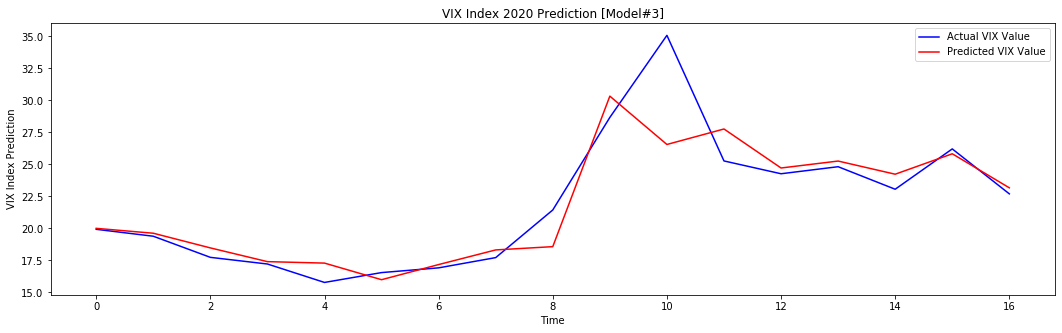

The RMSE of this Model is 2.3718935082904187


In [153]:

ScaleGraphEval(y_pred3,'VIX Index 2020 Prediction [Model#3]')

# Final Model

In [155]:
#This is my 4th and last model 
regressor = Sequential()
#I added a third layer to see if doing so would improve my results 
regressor.add(LSTM(units = 150, activation='relu',return_sequences = True, input_shape=(X_train.shape[1],5)))
regressor.add(Dropout(0.15))
#Here I followed the same pattern of decreasing units at ever layer
regressor.add(LSTM(units = 100, activation='relu',return_sequences = True))
regressor.add(Dropout(0.15))
#I added a dropout of .15 to each layer 
regressor.add(LSTM(units = 80, activation='relu'))
regressor.add(Dropout(0.15))

regressor.add(Dense(1))

In [156]:

#Here I see that my model is set up to my exact specifications 
regressor.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 30, 150)           93600     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 150)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 100)           100400    
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 80)                57920     
_________________________________________________________________
dropout_7 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [157]:
regressor.compile(optimizer='adam', loss = 'mean_squared_error')

In [158]:
regressor.fit(X_train,y_train,epochs=180,batch_size=50)

Epoch 1/180
50/50 [==============================] - 2s 43ms/step - loss: 0.0050
Epoch 2/180
50/50 [==============================] - 2s 42ms/step - loss: 0.0026
Epoch 3/180
50/50 [==============================] - 2s 41ms/step - loss: 0.0019
Epoch 4/180
50/50 [==============================] - 2s 40ms/step - loss: 0.0018
Epoch 5/180
50/50 [==============================] - 2s 40ms/step - loss: 0.0013
Epoch 6/180
50/50 [==============================] - 2s 41ms/step - loss: 0.0013
Epoch 7/180
50/50 [==============================] - 2s 42ms/step - loss: 0.0013
Epoch 8/180
50/50 [==============================] - 2s 39ms/step - loss: 0.0011
Epoch 9/180
50/50 [==============================] - 2s 40ms/step - loss: 0.0011
Epoch 10/180
50/50 [==============================] - 2s 40ms/step - loss: 9.4951e-04
Epoch 11/180
50/50 [==============================] - 2s 40ms/step - loss: 8.9876e-04
Epoch 12/180
50/50 [==============================] - 2s 39ms/step - loss: 9.8829e-04
Epoch 13/180


In [159]:
y_pred4 = regressor.predict(X_test)

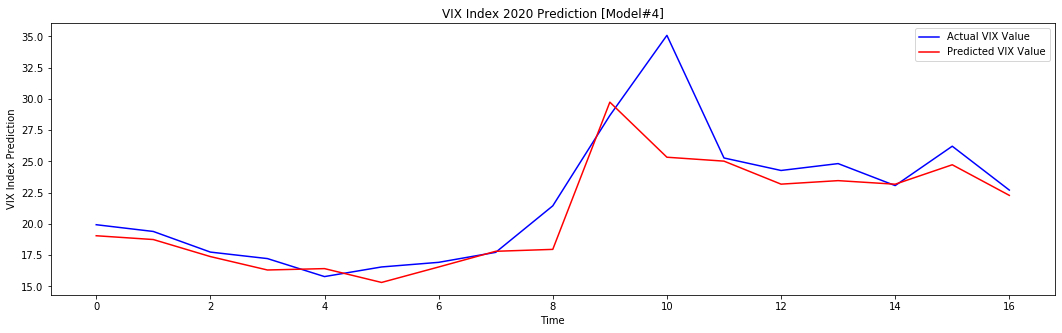

The RMSE of this Model is 2.6356555138029427


In [160]:
ScaleGraphEval(y_pred4,'VIX Index 2020 Prediction [Model#4]')
#This is my Final Model